In [74]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




```
HybridModelFCLSTM(
  (hybridNetwork): Sequential(
    (0): Linear(in_features=61, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.3, inplace=False)
    (5): LSTM(200, 200, dropout=0.3)
  )
  (endLinearLayer): Linear(in_features=200, out_features=24, bias=True)
)

```



In [75]:
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [76]:
config = {
    "data": {
        "window_size": 200,
        "train_split_size": 0.60,
        "validation_split_size": 0.30,  # in un secondo momento faremo la cross-validation
        "test_split_size": 0.10,

    },
    "model": {
        "input_size": 61,
        "num_lstm_layers": 1,
        "lstm_size": 200,
        "dropout": 0.3,
        "num_class": 1,
        "model_path": "Model/modelLSTMV0.pth",
        "model_name": "LSTMV0.txt",
        "save_model": True,
        "NstepsAhead": 24,
    },
    "training": {
        "device": "cuda",  # "cuda" or "cpu"
        "batch_size": 64,
        "num_epochs": 100,
        "learning_rate": 3e-4,
        "weight_decay": 0.001,
        "momentum": 0.9,
        "loss_function": nn.MSELoss(),
        "optimizer": torch.optim.Adam,
        "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau,
        "scheduler_patience": 3 ,
        "scheduler_factor": 0.5,
        "scheduler_min_lr": 1e-6,
        "early_stopping": True,
        "early_stopping_patience": 23,
        "forget_bias": 0.1,
    },
}
dataSet = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/FeatureEngineering&DATA/dataSetIMRNormalized.csv")
hlc3 = dataSet['hlc3']
dataSet.drop(labels=['hlc3'], axis=1, inplace=True)
dataSet.insert(0, 'hlc3', hlc3)

# Dataloading (sliding windows)
config["model"]["input_size"] = dataSet.shape[1]  # with 1 have number of features

dataSet.shape
dataSet.head()

,hlc3,open,high,low,close,volume,volume_quote,trades,taker_buy,taker_buy_quote,...,W-VWAP,VWMA,EOM,MFI,SPX500-DailyReturn%,SPXEMA20,DXY-DailyReturn%,DXYEMA200,dix,gex
0,0.077536,0.076492,0.078360,0.076710,0.077264,0.007794,0.002942,0.007087,0.007015,0.002648,...,0.078848,0.082743,0.799290,0.210812,0.369083,0.111036,0.665689,0.120685,0.134868,0.227206
1,0.075336,0.077117,0.076656,0.073740,0.075342,0.015177,0.005596,0.013741,0.010860,0.004006,...,0.077351,0.082111,0.794959,0.203926,0.369083,0.111036,0.665689,0.120685,0.134868,0.227206
2,0.074478,0.075332,0.076020,0.072804,0.074342,0.011800,0.004319,0.011005,0.010717,0.003930,...,0.076790,0.081467,0.797770,0.217142,0.369083,0.111036,0.665689,0.120685,0.134868,0.227206
3,0.075919,0.074462,0.076962,0.074679,0.075849,0.010617,0.003956,0.009718,0.010714,0.003989,...,0.076882,0.081068,0.797842,0.219784,0.369083,0.111036,0.665689,0.120685,0.134868,0.227206
4,0.076992,0.076016,0.078177,0.074186,0.078336,0.007947,0.002967,0.008716,0.008202,0.003064,...,0.077092,0.080816,0.796239,0.209097,0.369083,0.111036,0.665689,0.120685,0.134868,0.227206


In [77]:
def slidingWindowsAhead(df, windowSize, nStepsAhead):
  x = []
  y = []
  dataLen = df.shape[0] # n rows
# The iteration step is now 'nStepsAhead' instead of 1.
  for i in range(windowSize, dataLen, nStepsAhead):
      if i + nStepsAhead > dataLen:
          break  # If we do not have enough data to predict further, we break the loop.
    # '_x' will contain 'windowSize' values as input data
      _x = df.iloc[i-windowSize:i].values
    # '_y' will contain 'nStepsAhead' values as labels
      _y = df.iloc[i:i+nStepsAhead, 0].values  # Select first column after row selection

      x.append(_x)
      y.append(_y)
  return np.array(x), np.array(y)

In [78]:
mX , mY = slidingWindowsAhead(dataSet,config["data"]["window_size"],config["model"]["NstepsAhead"])

trainWnum = int(len(mX) * config["data"]["train_split_size"])
valWnum = int(len(mX) * config["data"]["validation_split_size"])
testWnum = len(mX) - trainWnum - valWnum  # Remaining data for testing
trX = mX[:trainWnum]
valX = mX[trainWnum:trainWnum+valWnum]
testX = mX[trainWnum+valWnum:]
trY = mY[:trainWnum]
valY = mY[trainWnum:trainWnum+valWnum]
testY = mY[trainWnum+valWnum:]



print("_______ Dim mX & mY ______")
print(f"dim mX:{mX.shape} dim mY:{mY.shape}")
print("_____Dimension X & Y _____")
print(f"dim trX:{trX.shape} --- dim trY:{trY.shape} ")
print(f"dim valX:{valX.shape} --- dim valY:{valY.shape} ")
print(f"dim testX:{testX.shape} --- dim testY:{testY.shape} ")





# Convert from numpy arrays to torch tensors
trX_tensor = torch.tensor(trX, dtype=torch.float32)
trY_tensor = torch.tensor(trY, dtype=torch.float32).unsqueeze(1)
valX_tensor = torch.tensor(valX, dtype=torch.float32)
valY_tensor = torch.tensor(valY, dtype=torch.float32).unsqueeze(1)
testX_tensor = torch.tensor(testX, dtype=torch.float32)
testY_tensor = torch.tensor(testY, dtype=torch.float32).unsqueeze(1)

print("_____Dimension X & Y tensor _____")
print(f"dim trX:{trX_tensor.shape} --- dim trY:{trY_tensor.shape} ")
print(f"dim valX:{valX_tensor.shape} --- dim valY:{valY_tensor.shape} ")
print(f"dim testX:{testX_tensor.shape} --- dim testY:{testY_tensor.shape} ")


# capire la dimmensione di Mx




_______ Dim mX & mY ______
dim mX:(2158, 200, 61) dim mY:(2158, 24)
_____Dimension X & Y _____
dim trX:(1294, 200, 61) --- dim trY:(1294, 24) 
dim valX:(647, 200, 61) --- dim valY:(647, 24) 
dim testX:(217, 200, 61) --- dim testY:(217, 24) 
_____Dimension X & Y tensor _____
dim trX:torch.Size([1294, 200, 61]) --- dim trY:torch.Size([1294, 1, 24]) 
dim valX:torch.Size([647, 200, 61]) --- dim valY:torch.Size([647, 1, 24]) 
dim testX:torch.Size([217, 200, 61]) --- dim testY:torch.Size([217, 1, 24]) 


In [79]:
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, X_data, y_data):
        super(). __init__()
        self.X_data = X_data
        self.y_data = y_data

    def __len__(self):
        return len(self.X_data)

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]


# Create Dataset instances
train_dataset = TimeSeriesDataset(trX_tensor, trY_tensor)
val_dataset = TimeSeriesDataset(valX_tensor, valY_tensor)
test_dataset = TimeSeriesDataset(testX_tensor, testY_tensor)

# Create DataLoader instances
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=config["training"]["batch_size"],
                          shuffle=False)
""" bisogna fare una prova con shffle = True e False Tuttavia, per i dati strutturati come "finestre scorrevoli" (sliding windows), dove ogni campione è indipendente e contiene le informazioni temporali necessarie nel contesto della finestra stessa, l'operazione di shuffle potrebbe non essere dannosa. In questo caso, ogni finestra agisce come un campione indipendente e il modello impara da queste finestre piuttosto che dalla sequenza complessiva """
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=config["training"]["batch_size"],
                        shuffle=False)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=config["training"]["batch_size"],
                         shuffle=False)

In [80]:
class CNNLSTMModel(nn.Module):

  def __init__(self, input_size, num_lstm_layers, dropout, num_class,
               sequence_length):
    super().__init__()

    # Definizione del modello usando nn.Sequential
    self.hybridNetwork = nn.Sequential(
        nn.Conv1d(in_channels=input_size,
                  out_channels=sequence_length,
                  kernel_size=1),
        nn.ReLU(),
        nn.LSTM(input_size=sequence_length,
                hidden_size=sequence_length,
                num_layers=num_lstm_layers,
                dropout=dropout,
                batch_first=False),
    )
    self.endLinearLayer = nn.Linear(sequence_length,config["model"]["NstepsAhead"])

  def forward(self, x):
    # Apply CNN layers
    x = x.permute(0, 2, 1)
    x = self.hybridNetwork[0](x)  # Conv1d
    x = self.hybridNetwork[1](x)  # ELU activation

    # Permute the dimensions for LSTM
    x = x.permute(2, 0, 1)

    # Apply LSTM layers
    x, (hidden, cell) = self.hybridNetwork[2](x)

    # Only take the output from the last time-step
    x = x[-1, :, :]

    # Apply final linear layer
    x = self.endLinearLayer(x)
    return x

In [81]:
hybridModelCNNLSTML1L2_24h = CNNLSTMModel(
    input_size=61,
    num_lstm_layers=config["model"]["num_lstm_layers"],
    dropout=config["model"]["dropout"],
    num_class=1,
    sequence_length=config["data"]["window_size"])
print(hybridModelCNNLSTML1L2_24h)
hybridModelCNNLSTML1L2_24h.to(config["training"]["device"])

# Parameters for regularization
l1_regularization = True
l1_factor = 1e-5
train_hist = []
val_hist = []
test_hist = []
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(hybridModelCNNLSTML1L2_24h.parameters(),
                             lr=config["training"]["learning_rate"],weight_decay=config["training"]["weight_decay"]) # L2 reg

scheduler = config["training"]["scheduler"](
    optimizer,
    patience=config["training"]["scheduler_patience"],
    factor=config["training"]["scheduler_factor"],
    min_lr=config["training"]["scheduler_min_lr"])
best_val_loss = float('inf')
patience_counter = 0
loss_list = []
test_loss_list = []
# of accuracy for a regression model, with bootstrapping 95% of confident predictions


CNNLSTMModel(
  (hybridNetwork): Sequential(
    (0): Conv1d(61, 200, kernel_size=(1,), stride=(1,))
    (1): ReLU()
    (2): LSTM(200, 200, dropout=0.3)
  )
  (endLinearLayer): Linear(in_features=200, out_features=24, bias=True)
)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [82]:
def trainLoop(model, train_loader, optimizer, scheduler, loss_fn):
  model.train()
  train_loss = 0
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(config["training"]["device"]), target.to(
        config["training"]["device"])
    optimizer.zero_grad()
    output = model(data)
    loss = loss_fn(output, target)
    if l1_regularization:
      # Manually add L1 regularization term
      l1_penalty = sum(p.abs().sum() for p in model.parameters()) * l1_factor
      loss += l1_penalty
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  avg_loss = train_loss / len(train_loader)
  print(f"Train loss: {avg_loss}")
  return train_loss, avg_loss


def valLoop(model, val_loader, loss_fn):
  model.eval()
  val_loss = 0
  with torch.no_grad():
    for batch_idx, (data, target) in enumerate(val_loader):
      data, target = data.to(config["training"]["device"]), target.to(
          config["training"]["device"])
      output = model(data)
      loss = loss_fn(output, target)
      val_loss += loss.item()
  avg_loss = val_loss / len(val_loader)
  print(f"Validation loss: {avg_loss}")
  return val_loss, avg_loss


def testLoop(model, test_loader, loss_fn):
  model.eval()
  test_loss = 0
  all_predictions = []
  all_targets = []
  with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
      data, target = data.to(config["training"]["device"]), target.to(
          config["training"]["device"])
      output = model(data)
      loss = loss_fn(output, target)
      test_loss += loss.item()

      all_predictions.extend(
          output.squeeze().tolist())  # Flatten and accumulate predictions
      all_targets.extend(
          target.squeeze().tolist())  # Flatten and accumulate actual values

      # Calculate metrics
  mse = mean_squared_error(all_targets, all_predictions)
  print(f"Test  MSE:{mse} ")
  MAE = mean_absolute_error(all_targets, all_predictions)
  print(f'Test Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
  MAPE = np.mean((np.abs(np.subtract(all_targets, all_predictions)/ all_targets))) * 100
  print(f'Test Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
  MDAPE = np.median((np.abs(np.subtract(all_targets, all_predictions)/ all_targets)) ) * 100
  print(f'Test Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
  mse = mean_squared_error(all_targets, all_predictions)
  rmse = mean_squared_error(all_targets, all_predictions, squared=False)
  mae = mean_absolute_error(all_targets, all_predictions)
  r2 = r2_score(all_targets, all_predictions)
  test_loss /= len(test_loader.dataset)
  return all_predictions,all_targets,test_loss, mse, rmse, mae, r2,MAE,MAPE,MDAPE

### controllare affondo che il ciclo di epoca sia apposto in particolare ho trovato dei problemi nella restituzione delle los che erano le cumulate e non le medie e venivano usate in modo erroneo ho sistmato la cosa ma devi verificare


prova a fare vari tentativi con finestre di dimmensione minore

In [83]:
"""
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

# epoch loop
for epoch in range(config["training"]["num_epochs"]):
    trainCum_loss, avg_train_loss = trainLoop(hybridModelCNNLSTML1L2_24h, train_loader, optimizer, scheduler, loss_fn)
    writer.add_scalar("Loss/train", avg_train_loss, epoch)
    valCum_loss, avg_val_loss = valLoop(hybridModelCNNLSTML1L2_24h, val_loader, loss_fn)
    writer.add_scalar("Loss/val", avg_val_loss, epoch)
    train_hist.append(avg_train_loss)
    val_hist.append(avg_val_loss)
    print(f"Epoch: {epoch} train loss: {avg_train_loss} val loss: {avg_val_loss} \n")


    # Controllare il salvataggio del miglior modello per l'epoca corrente
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0


    else:
        patience_counter += 1
    # Controllare l'early stopping
    if patience_counter > config["training"]["early_stopping_patience"]:
        print("Early stopping triggered.")
        break

    scheduler.step(avg_val_loss)

# model performance evalutation
writer.flush()
all_predictions,all_targets,test_loss, mse, rmse, mae, r2,MAE,MAPE,MDAPE = testLoop(hybridModelCNNLSTML1L2_24h, test_loader, loss_fn)

# test_loss, mse, rmse, mae, r2 = testLoop(HybridModelV1, test_loader, loss_fn)
print(f"Test Loss: {test_loss:.10f}")
print(f"MSE: {mse:.10f}")
print(f"RMSE: {rmse:.10f}")
print(f"MAE: {mae:.10f}")
print(f"R^2: {r2:.10f}")
print(f"MAE:{MAE:.10f}")
print(f"MAPE:{MAPE:.10f}")
print(f"MDAPE:{MDAPE:.10f}")

"""

'\nfrom torch.utils.tensorboard import SummaryWriter\nwriter = SummaryWriter()\n\n# epoch loop\nfor epoch in range(config["training"]["num_epochs"]):\n    trainCum_loss, avg_train_loss = trainLoop(hybridModelCNNLSTML1L2_24h, train_loader, optimizer, scheduler, loss_fn)\n    writer.add_scalar("Loss/train", avg_train_loss, epoch)\n    valCum_loss, avg_val_loss = valLoop(hybridModelCNNLSTML1L2_24h, val_loader, loss_fn)\n    writer.add_scalar("Loss/val", avg_val_loss, epoch)\n    train_hist.append(avg_train_loss)\n    val_hist.append(avg_val_loss)\n    print(f"Epoch: {epoch} train loss: {avg_train_loss} val loss: {avg_val_loss} \n")\n\n\n    # Controllare il salvataggio del miglior modello per l\'epoca corrente\n    if avg_val_loss < best_val_loss:\n        best_val_loss = avg_val_loss\n        patience_counter = 0\n\n\n    else:\n        patience_counter += 1\n    # Controllare l\'early stopping\n    if patience_counter > config["training"]["early_stopping_patience"]:\n        print("Earl

In [84]:
def prepare_df1(x, y, y_pred):
    # Undo the scaling on x, reshape the testset into a one-dimensional array, so that it fits to the pred scaler
    x_test_unscaled_df = pd.DataFrame({'x_test': x[:, 0]})
    y_test_unscaled_df = pd.DataFrame({'y_test': y})
    y_pred_df = pd.DataFrame({'y_pred': y_pred})

    return x_test_unscaled_df, y_pred_df, y_test_unscaled_df



def plot_multi_test_forecast(x_test, y_test, y_pred, title):
    # Create DataFrames for x_test, y_pred, and y_test
    df_merge = y_pred.join(y_test, how='left')
    df_merge1 = pd.concat([x_test, df_merge]).reset_index(drop=True)
    fig, ax = plt.subplots(figsize=(20, 8))
    plt.title(title, fontsize=12)
    ax.set(ylabel =  "BTC- hlc3 quotes")
    sns.lineplot(data = df_merge1, linewidth=2.0, ax=ax)




In [85]:
def trainLoopT(model, train_loader):
  all_predictions = []
  all_targets = []
  train_loss = 0
  with torch.no_grad():
    for batch_idx, (data, target) in enumerate(train_loader):
      data, target = data.to(config["training"]["device"]), target.to(
        config["training"]["device"])
      target = target.squeeze(1)
      output = model(data)
      loss = loss_fn(output, target)
      train_loss += loss.item()
      all_predictions.extend(
        output.squeeze().tolist())  # Flatten and accumulate predictions
      all_targets.extend(
        target.squeeze().tolist())


    avg_loss = train_loss / len(train_loader)
  print(f"Train loss: {avg_loss}")
  return train_loss, avg_loss,all_predictions,all_targets


### TRAINING SET

In [86]:
model = CNNLSTMModel(
    input_size=61,
    num_lstm_layers=config["model"]["num_lstm_layers"],
    dropout=config["model"]["dropout"],
    num_class=1,
    sequence_length=config["data"]["window_size"])

model.to(config["training"]["device"])


model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Model-PTH/hybridCNNLSTM24h_L1L2Verified_epoch_49_loss_0.0665.pth'))
model.eval()




print(f"trX input: {trX_tensor.shape}")
Xinput = trX_tensor[1,:,1]
Xinput_numpy = Xinput.detach().cpu().numpy().flatten()

inputTest = trX_tensor[1,:,:]
y_true = trY_tensor[0,:]
print(f"Xinput:{Xinput.shape} --- y_true:{y_true.shape} ---- inputtest:{inputTest.shape} ")

train_loss,avg_loss,all_predictions,all_targets = trainLoopT(model,train_loader)

print("Results________:")
print(f"AVG train test error over trainDataSet:{avg_loss}")
print(f"all_predictions dim {len(all_predictions)} & all_targets dim {len(all_targets)}")
#print(f"pred1 {all_predictions[1]} & target {all_targets[1]}")


class TestResults:
  def __init__(self, Xinput, y_true, y_pred, mse, rmse, r2):
      self.Xinput = Xinput
      self.y_true = y_true
      self.y_pred = y_pred
      self.mse = mse
      self.rmse = rmse
      self.r2 = r2


  def to_dataframe(self):
    return pd.DataFrame({
      "y_true": self.y_true,
      "y_pred": self.y_pred,
  })

  def resultPerformance(self):
    return pd.DataFrame({
          "MSE": [self.mse],
          "RMSE": [self.rmse],
          "R2": [self.r2]
      })
  def setMse(self, mse):
    self.mse = mse
  def setRmse(self, rmse):
    self.rmse = rmse
  def setR2(self, r2):
    self.r2 = r2

  def plot_results(self):
    df = self.to_dataframe()
    plt.figure(figsize=(15, 5))
        # Assuming the first item in "Xinput", "y_true", "y_pred" lists are what we want to plot
        # If "Xinput", "y_true", "y_pred" are nested lists, take the first element for plotting
    x_range = range(len(df['y_true'][0])) if isinstance(df['y_true'][0], list) else range(len(df['y_true']))
        # Xinput may not be used in scatter plot if its shape does not conform to the others
    plt.scatter(x_range, df['y_true'][0], label='True Value', color='blue')  # Assume first instance
    plt.scatter(x_range, df['y_pred'][0], label='Predicted Value', color='red')  # Assume first instance

    plt.title('Test Results')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

TestResult = TestResults(Xinput, all_targets, all_predictions, 0, 0,0)

trX input: torch.Size([1294, 200, 61])
Xinput:torch.Size([200]) --- y_true:torch.Size([1, 24]) ---- inputtest:torch.Size([200, 61]) 
Train loss: 0.0006551300607714525
Results________:
AVG train test error over trainDataSet:0.0006551300607714525
all_predictions dim 1294 & all_targets dim 1294


devi per ogni elemento della finestra calcolare MSE  e vedere come varia e calcolare R2 finestra per finestra inoltre fai una cella dialogo in cui c'è la spiegazione e le formule di R2 e MSE. Fai un grafico val input+ pred + val vero e fai uno scatter





In [87]:
TestResult_df = TestResult.to_dataframe()
y_true = TestResult_df["y_true"]
y_pred = TestResult_df["y_pred"]
# If y_true and y_pred are lists of lists, we need to flatten them
# Flattening only needs to happen if y_true and y_pred are indeed lists of lists
y_true_flat = [item for sublist in y_true for item in sublist] if isinstance(y_true.iloc[0], list) else y_true
y_pred_flat = [item for sublist in y_pred for item in sublist] if isinstance(y_pred.iloc[0], list) else y_pred
# Now calculate the MSE, RMSE, and R2 score using the flattened lists
mse_test = mean_squared_error(y_true_flat, y_pred_flat)
rmse_test = mean_squared_error(y_true_flat, y_pred_flat, squared=False)
r2_test = r2_score(y_true_flat, y_pred_flat)
# Print the results
print(f"Test MSE: {mse_test}")
print(f"Test RMSE: {rmse_test}")
print(f"Test R2: {r2_test}")
# Update the TestResult object with the new computed metrics
TestResult.setMse(mse_test)
TestResult.setRmse(rmse_test)
TestResult.setR2(r2_test)

TestResult.resultPerformance().head()

Test MSE: 0.000638258710407343
Test RMSE: 0.025263782583123673
Test R2: 0.9878613216375386


,MSE,RMSE,R2
0,0.000638,0.025264,0.987861


In [88]:
# ora cal MSE elemento per elemento della finestra


dfWresult = pd.DataFrame()


dfWresult["Y_true"] = y_true_flat
dfWresult["Y_pred"] = y_pred_flat




for i in range(len(dfWresult)):
   # Ensure the true and predicted values are passed as lists
   mse = mean_squared_error([dfWresult.at[i,"Y_true"]], [dfWresult.at[i,"Y_pred"]])
   dfWresult.at[i, "mse"] = mse

mse_mean = mean_squared_error(dfWresult["Y_true"], dfWresult["Y_pred"])

print(f"Mean MSE over dataset: {mse_mean}")

mse_mean1 = dfWresult["mse"].mean()


Mean MSE over dataset: 0.000638258710407343


In [89]:
print(dfWresult.head(125))

       Y_true    Y_pred           mse
0    0.093349  0.099071  3.274189e-05
1    0.093879  0.095986  4.436506e-06
2    0.092606  0.106008  1.796028e-04
3    0.093008  0.096025  9.106071e-06
4    0.093360  0.099758  4.093574e-05
..        ...       ...           ...
120  0.119230  0.120788  2.428334e-06
121  0.120373  0.118298  4.306312e-06
122  0.121433  0.126762  2.840306e-05
123  0.122008  0.120343  2.772237e-06
124  0.121224  0.121151  5.325852e-09

[125 rows x 3 columns]


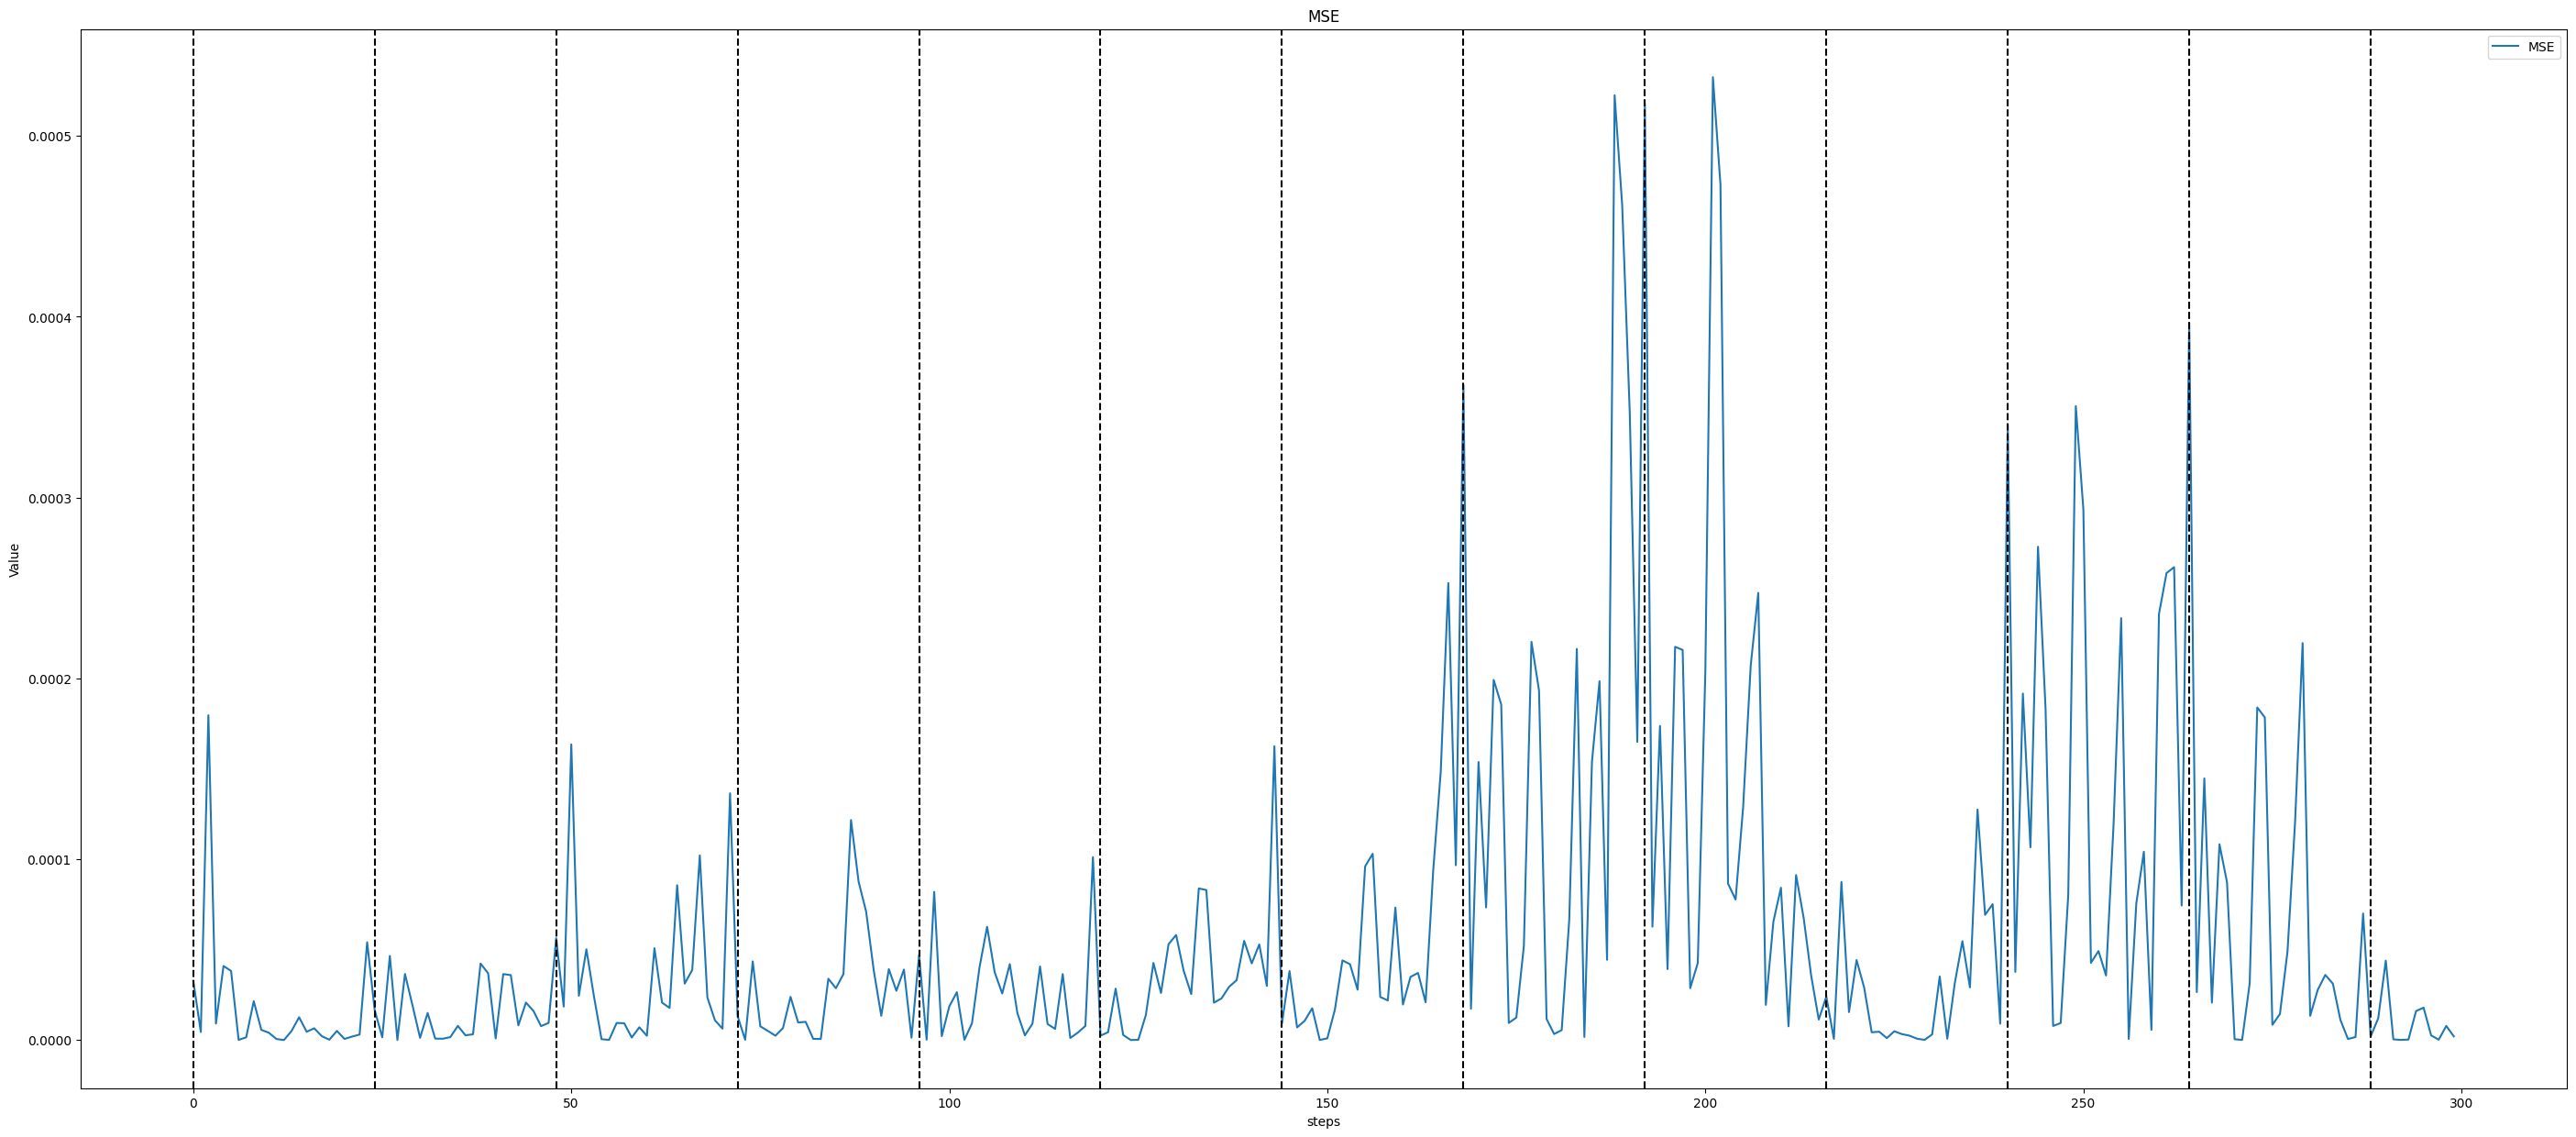

In [90]:


plt.figure(figsize=(35, 15))
plt.plot(dfWresult["mse"].iloc[:300], label='MSE')  # Corrected line
# Insert a vertical line every 24 steps
for i in range(0, 300, 24):
    plt.axvline(x=i, color='k', linestyle='--')
plt.title('MSE')
plt.xlabel('steps')
plt.ylabel('Value')
plt.legend()
plt.show()

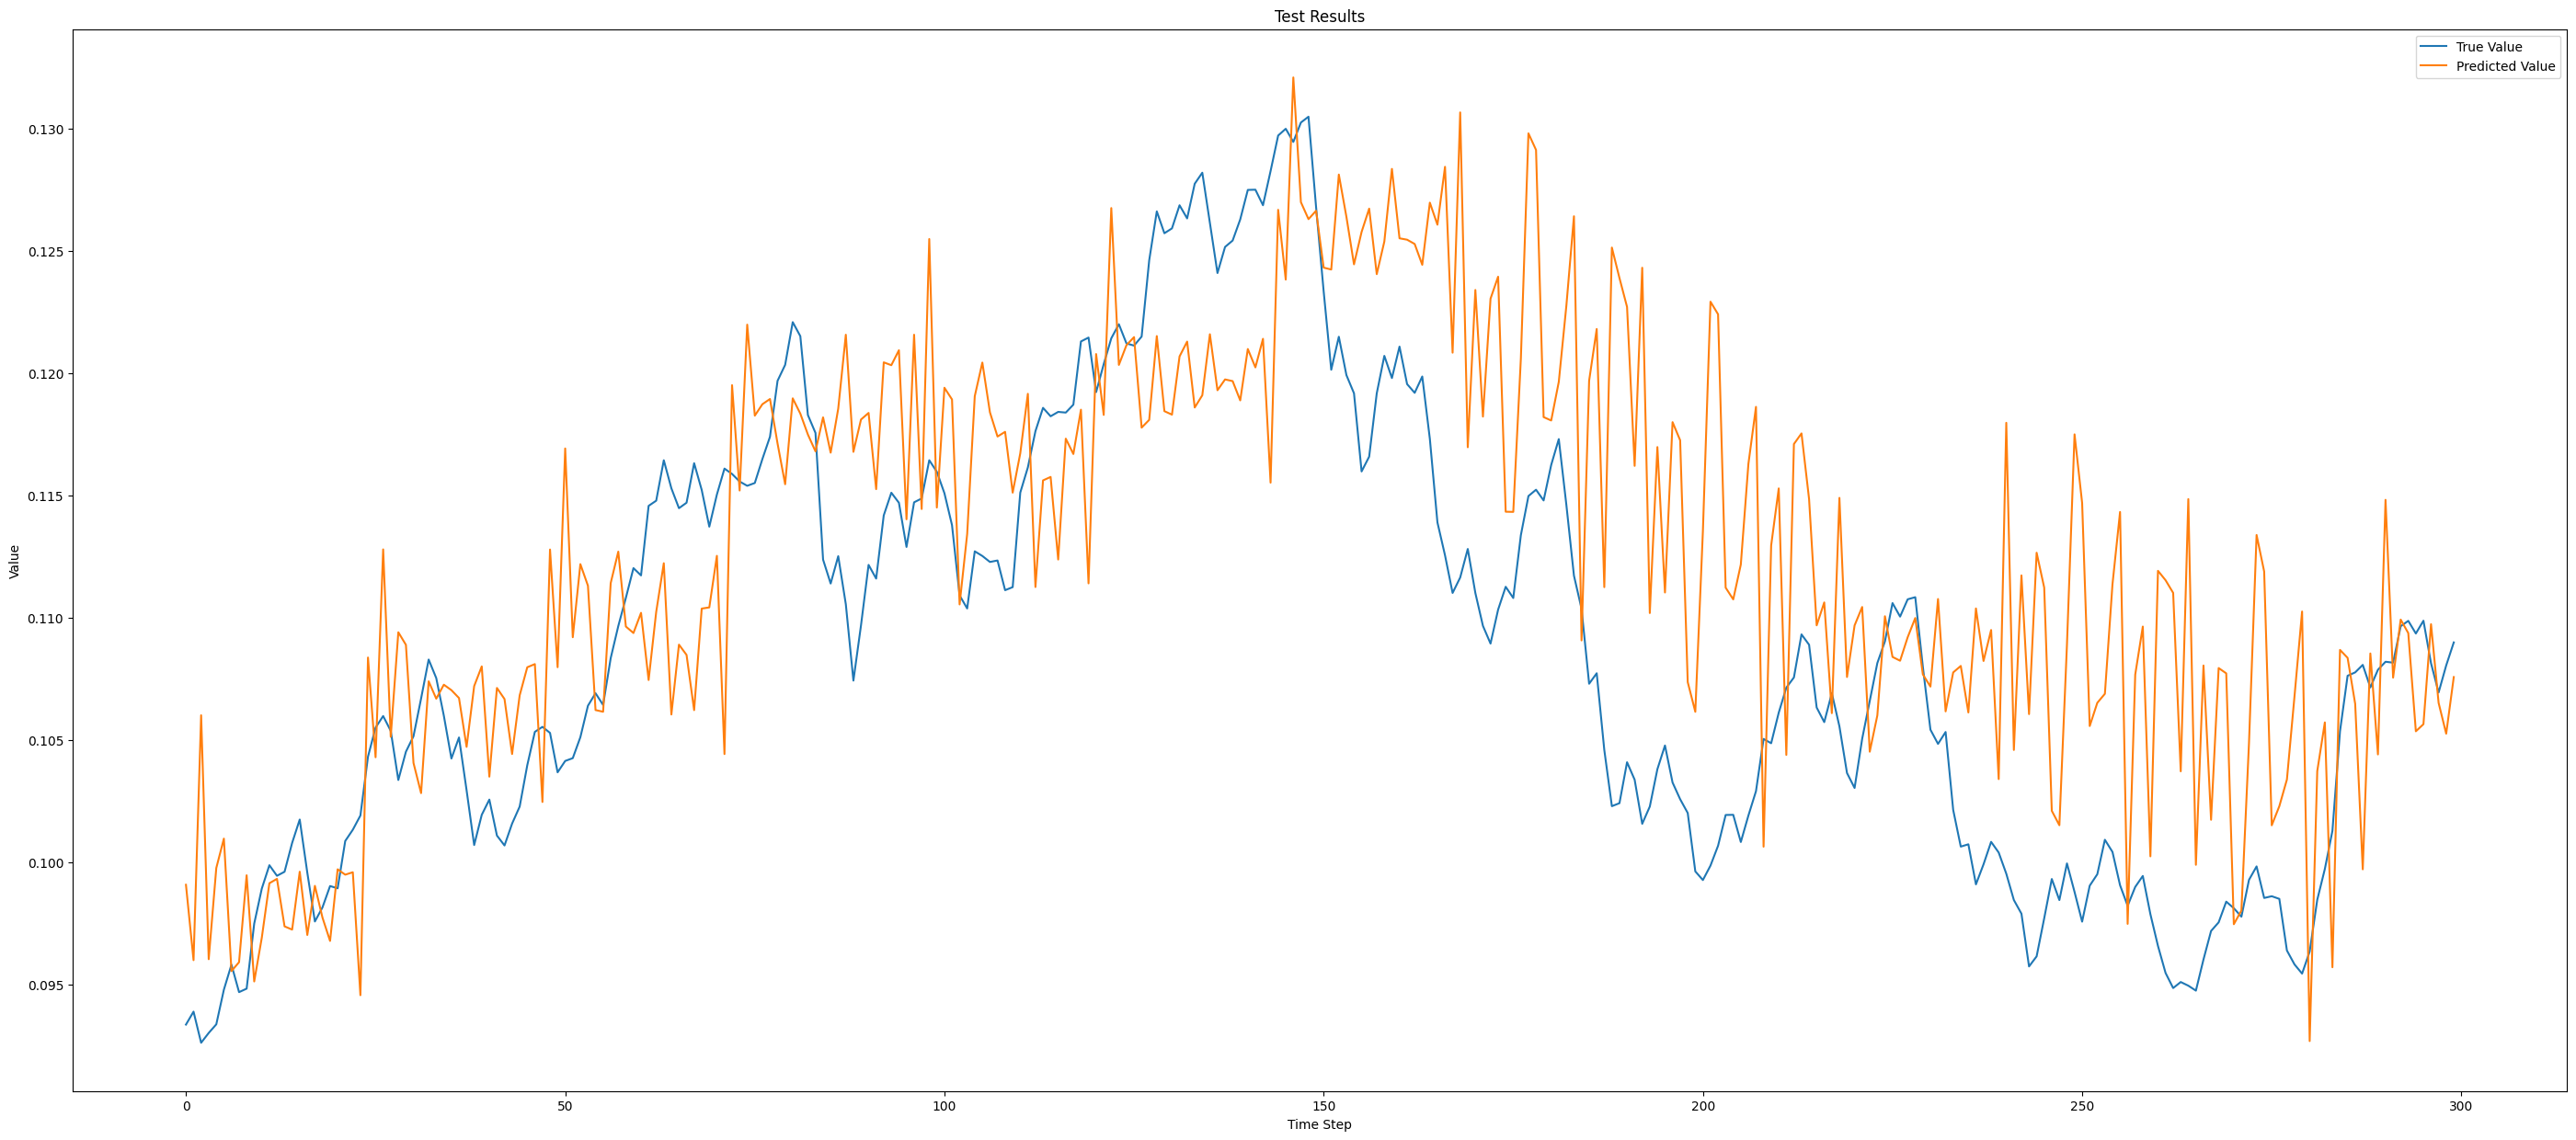

In [91]:
plt.figure(figsize=(35, 15))
plt.plot(y_true_flat[:300], label='True Value')
plt.plot(y_pred_flat[:300], label='Predicted Value')

plt.title('Test Results')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()


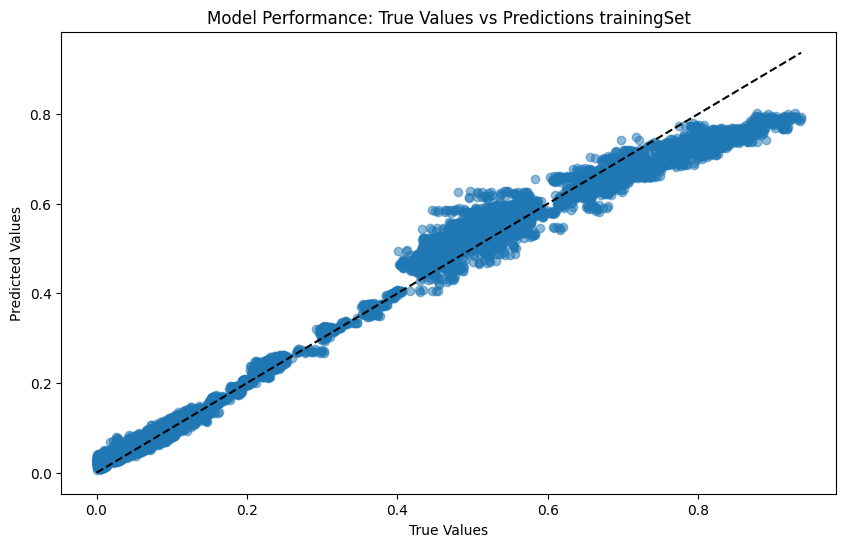

In [92]:
import matplotlib.pyplot as plt
import numpy as np  # Import numpy if it's not already

# Assuming y_true_flat and y_pred_flat are lists, convert them to NumPy arrays
y_true_flat_np = np.array(y_true_flat)
y_pred_flat_np = np.array(y_pred_flat)

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_true_flat_np, y_pred_flat_np, alpha=0.5)
plt.title('Model Performance: True Values vs Predictions trainingSet')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

# Plot the perfect prediction line
max_val = max(y_true_flat_np.max(), y_pred_flat_np.max())
min_val = min(y_true_flat_np.min(), y_pred_flat_np.min())
plt.plot([min_val, max_val], [min_val, max_val], 'k--')

plt.show()


In [93]:

"""
append() aggiunge l'intero oggetto (in questo caso, la lista list2)
 come un singolo elemento alla fine della lista.

extend() aggiunge gli elementi dell'iterabile
(in questo caso, gli elementi di list2) singolarmente alla fine della lista.

"""

"\nappend() aggiunge l'intero oggetto (in questo caso, la lista list2)\n come un singolo elemento alla fine della lista.\n\nextend() aggiunge gli elementi dell'iterabile\n(in questo caso, gli elementi di list2) singolarmente alla fine della lista.\n\n"

### VALIDATION SET


In [94]:
train_loss,avg_loss,all_predictions,all_targets = trainLoopT(model,val_loader)

print("Results________:")
print(f"AVG val test error over trainDataSet:{avg_loss}")
print(f"all_predictions dim {len(all_predictions)} & all_targets dim {len(all_targets)}")
#print(f"pred1 {all_predictions[1]} & target {all_targets[1]}")


class TestResults:
  def __init__(self, Xinput, y_true, y_pred, mse, rmse, r2):
      self.Xinput = Xinput
      self.y_true = y_true
      self.y_pred = y_pred
      self.mse = mse
      self.rmse = rmse
      self.r2 = r2

  def to_dataframe(self):
    return pd.DataFrame({
      "y_true": self.y_true,
      "y_pred": self.y_pred,
  })

  def resultPerformance(self):
    return pd.DataFrame({
          "MSE": [self.mse],
          "RMSE": [self.rmse],
          "R2": [self.r2]
      })
  def setMse(self, mse):
    self.mse = mse
  def setRmse(self, rmse):
    self.rmse = rmse
  def setR2(self, r2):
    self.r2 = r2

  def plot_results(self):
    df = self.to_dataframe()
    plt.figure(figsize=(15, 5))
        # Assuming the first item in "Xinput", "y_true", "y_pred" lists are what we want to plot
        # If "Xinput", "y_true", "y_pred" are nested lists, take the first element for plotting
    x_range = range(len(df['y_true'][0])) if isinstance(df['y_true'][0], list) else range(len(df['y_true']))
        # Xinput may not be used in scatter plot if its shape does not conform to the others
    plt.scatter(x_range, df['y_true'][0], label='True Value', color='blue')  # Assume first instance
    plt.scatter(x_range, df['y_pred'][0], label='Predicted Value', color='red')  # Assume first instance

    plt.title('Test Results')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

TestResult = TestResults(Xinput, all_targets, all_predictions, 0, 0,0)




Train loss: 0.0012006785926297941
Results________:
AVG val test error over trainDataSet:0.0012006785926297941
all_predictions dim 647 & all_targets dim 647


In [95]:
TestResult_df = TestResult.to_dataframe()
y_true = TestResult_df["y_true"]
y_pred = TestResult_df["y_pred"]
# If y_true and y_pred are lists of lists, we need to flatten them
# Flattening only needs to happen if y_true and y_pred are indeed lists of lists
y_true_flat = [item for sublist in y_true for item in sublist] if isinstance(y_true.iloc[0], list) else y_true
y_pred_flat = [item for sublist in y_pred for item in sublist] if isinstance(y_pred.iloc[0], list) else y_pred
# Now calculate the MSE, RMSE, and R2 score using the flattened lists
mse_test = mean_squared_error(y_true_flat, y_pred_flat)
rmse_test = mean_squared_error(y_true_flat, y_pred_flat, squared=False)
r2_test = r2_score(y_true_flat, y_pred_flat)
# Print the results
print(f"Test MSE: {mse_test}")
print(f"Test RMSE: {rmse_test}")
print(f"Test R2: {r2_test}")
# Update the TestResult object with the new computed metrics
TestResult.setMse(mse_test)
TestResult.setRmse(rmse_test)
TestResult.setR2(r2_test)

TestResult.resultPerformance().head()

Test MSE: 0.0012863273645988553
Test RMSE: 0.03586540623775026
Test R2: 0.9687515372681106


,MSE,RMSE,R2
0,0.001286,0.035865,0.968752


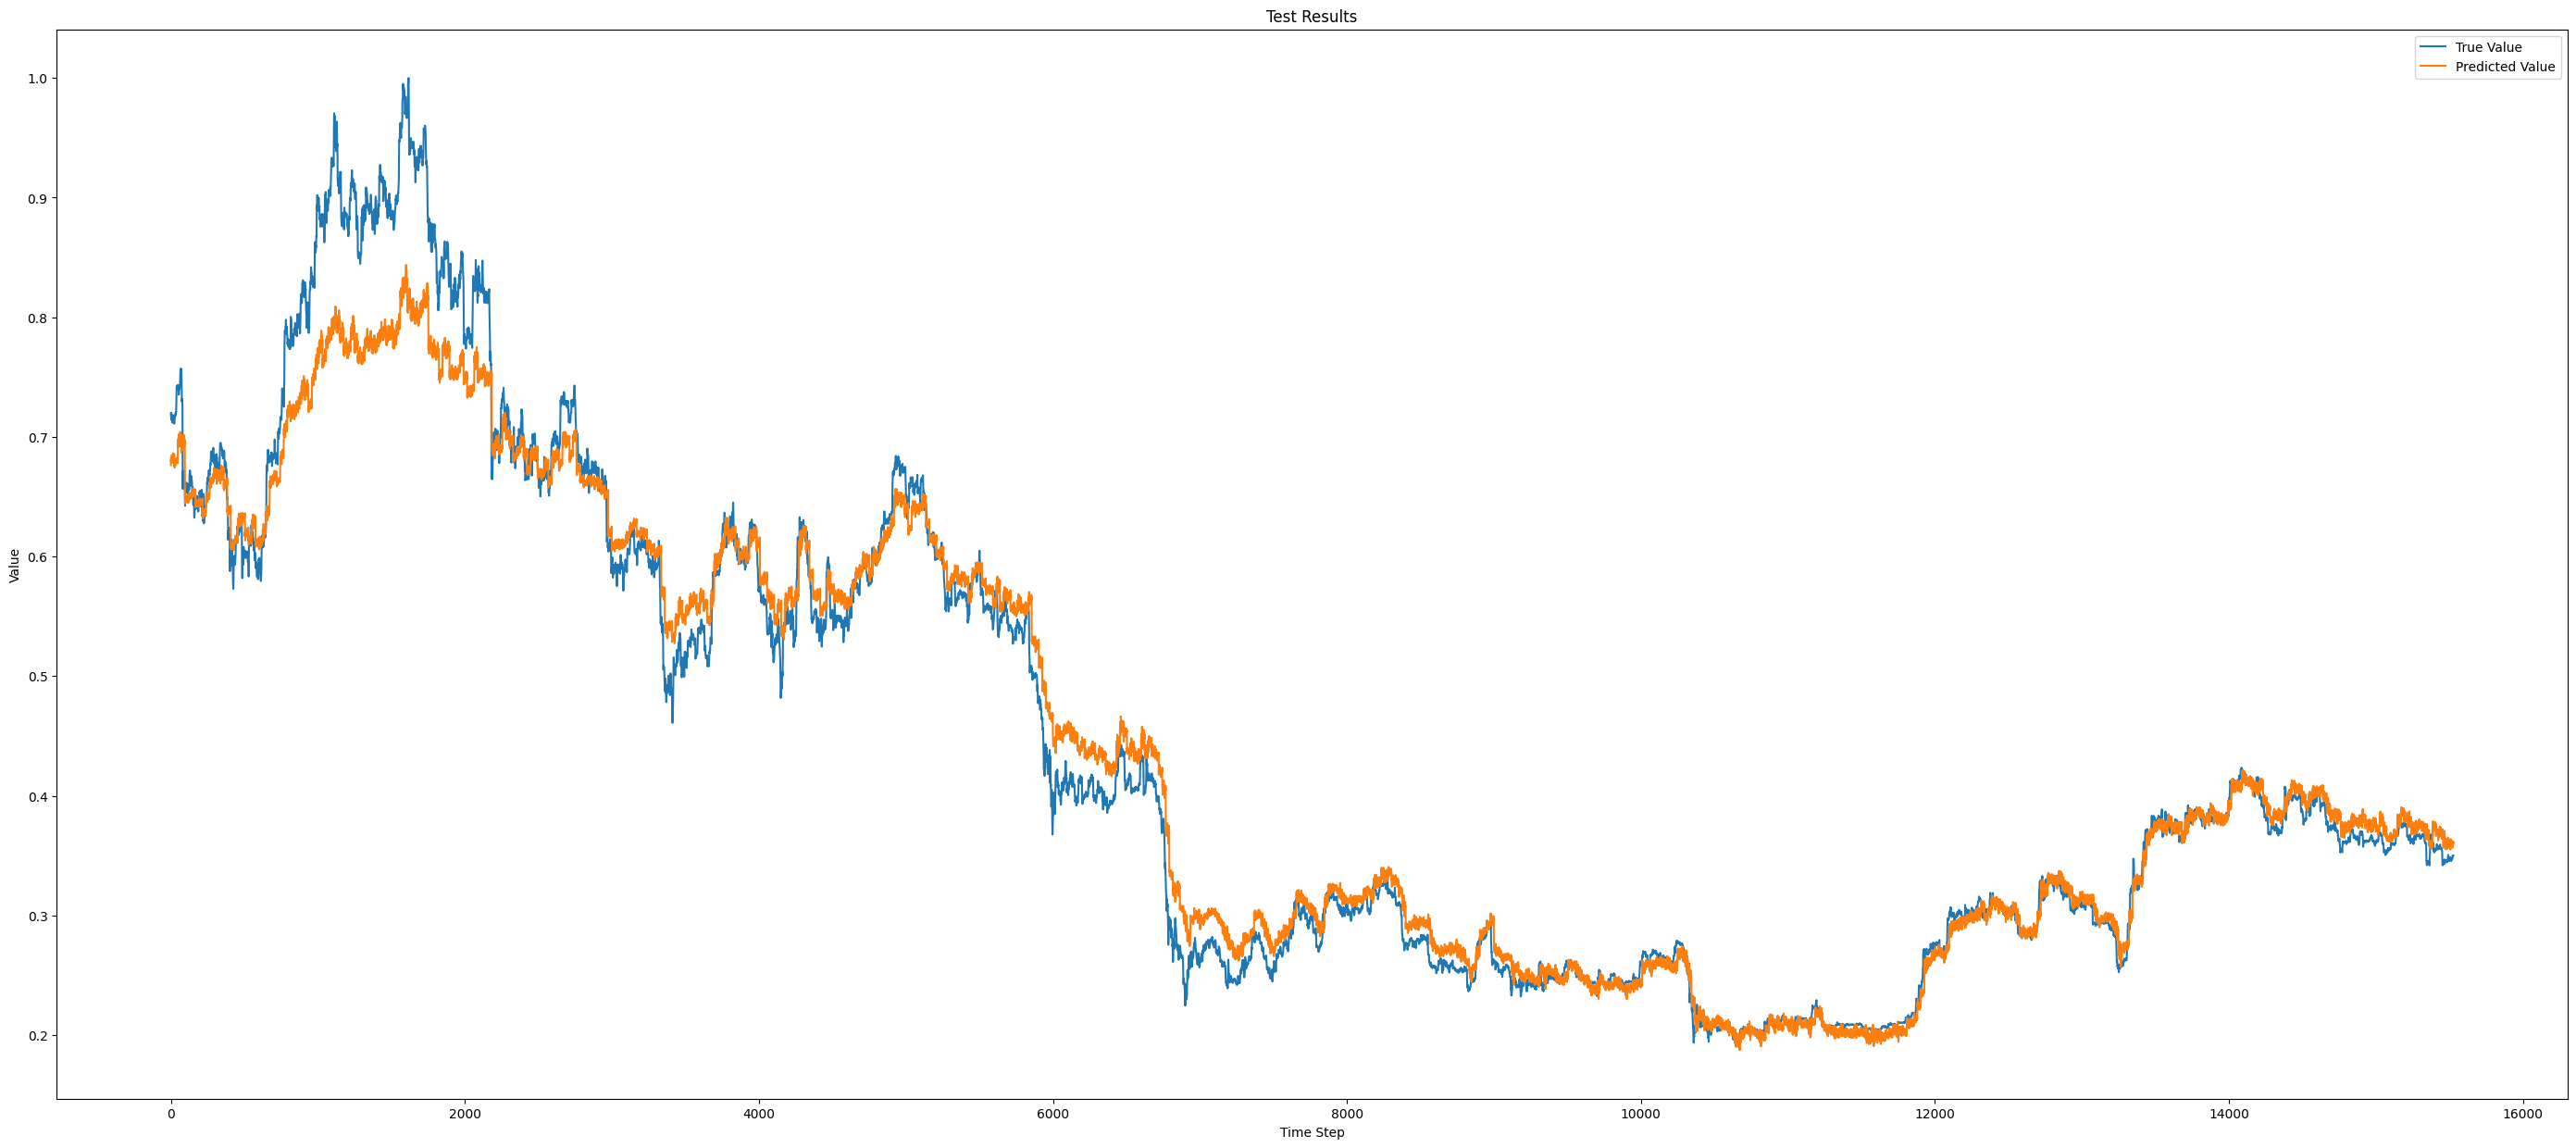

In [96]:

  plt.figure(figsize=(35, 15))
    #plt.plot(df['Xinput'], label='X input')
  plt.plot(y_true_flat[:-1], label='True Value')
  plt.plot(y_pred_flat[:-1], label='Predicted Value')
  plt.title('Test Results')
  plt.xlabel('Time Step')
  plt.ylabel('Value')
  plt.legend()
  plt.show()

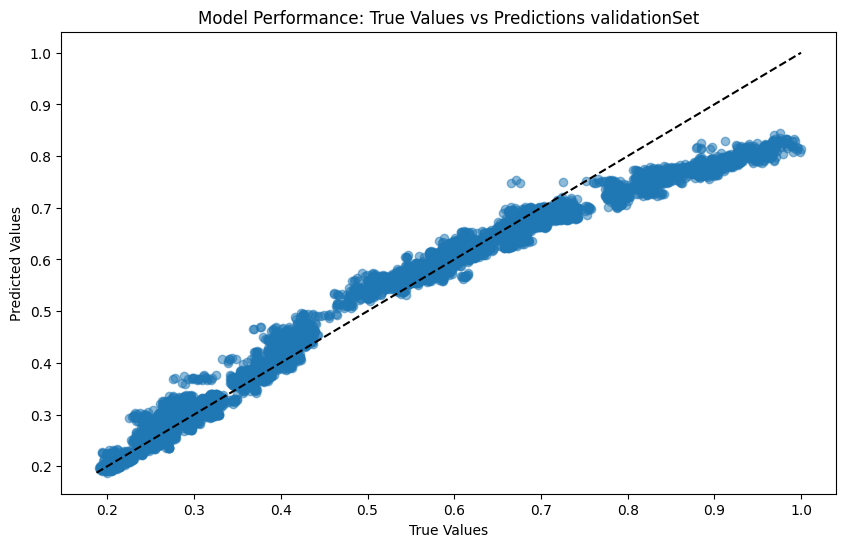

In [97]:
import matplotlib.pyplot as plt
import numpy as np  # Import numpy if it's not already

# Assuming y_true_flat and y_pred_flat are lists, convert them to NumPy arrays
y_true_flat_np = np.array(y_true_flat)
y_pred_flat_np = np.array(y_pred_flat)

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_true_flat_np, y_pred_flat_np, alpha=0.5)
plt.title('Model Performance: True Values vs Predictions validationSet')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

# Plot the perfect prediction line
max_val = max(y_true_flat_np.max(), y_pred_flat_np.max())
min_val = min(y_true_flat_np.min(), y_pred_flat_np.min())
plt.plot([min_val, max_val], [min_val, max_val], 'k--')

plt.show()

Mean MSE over dataset: 0.0012863273645988553


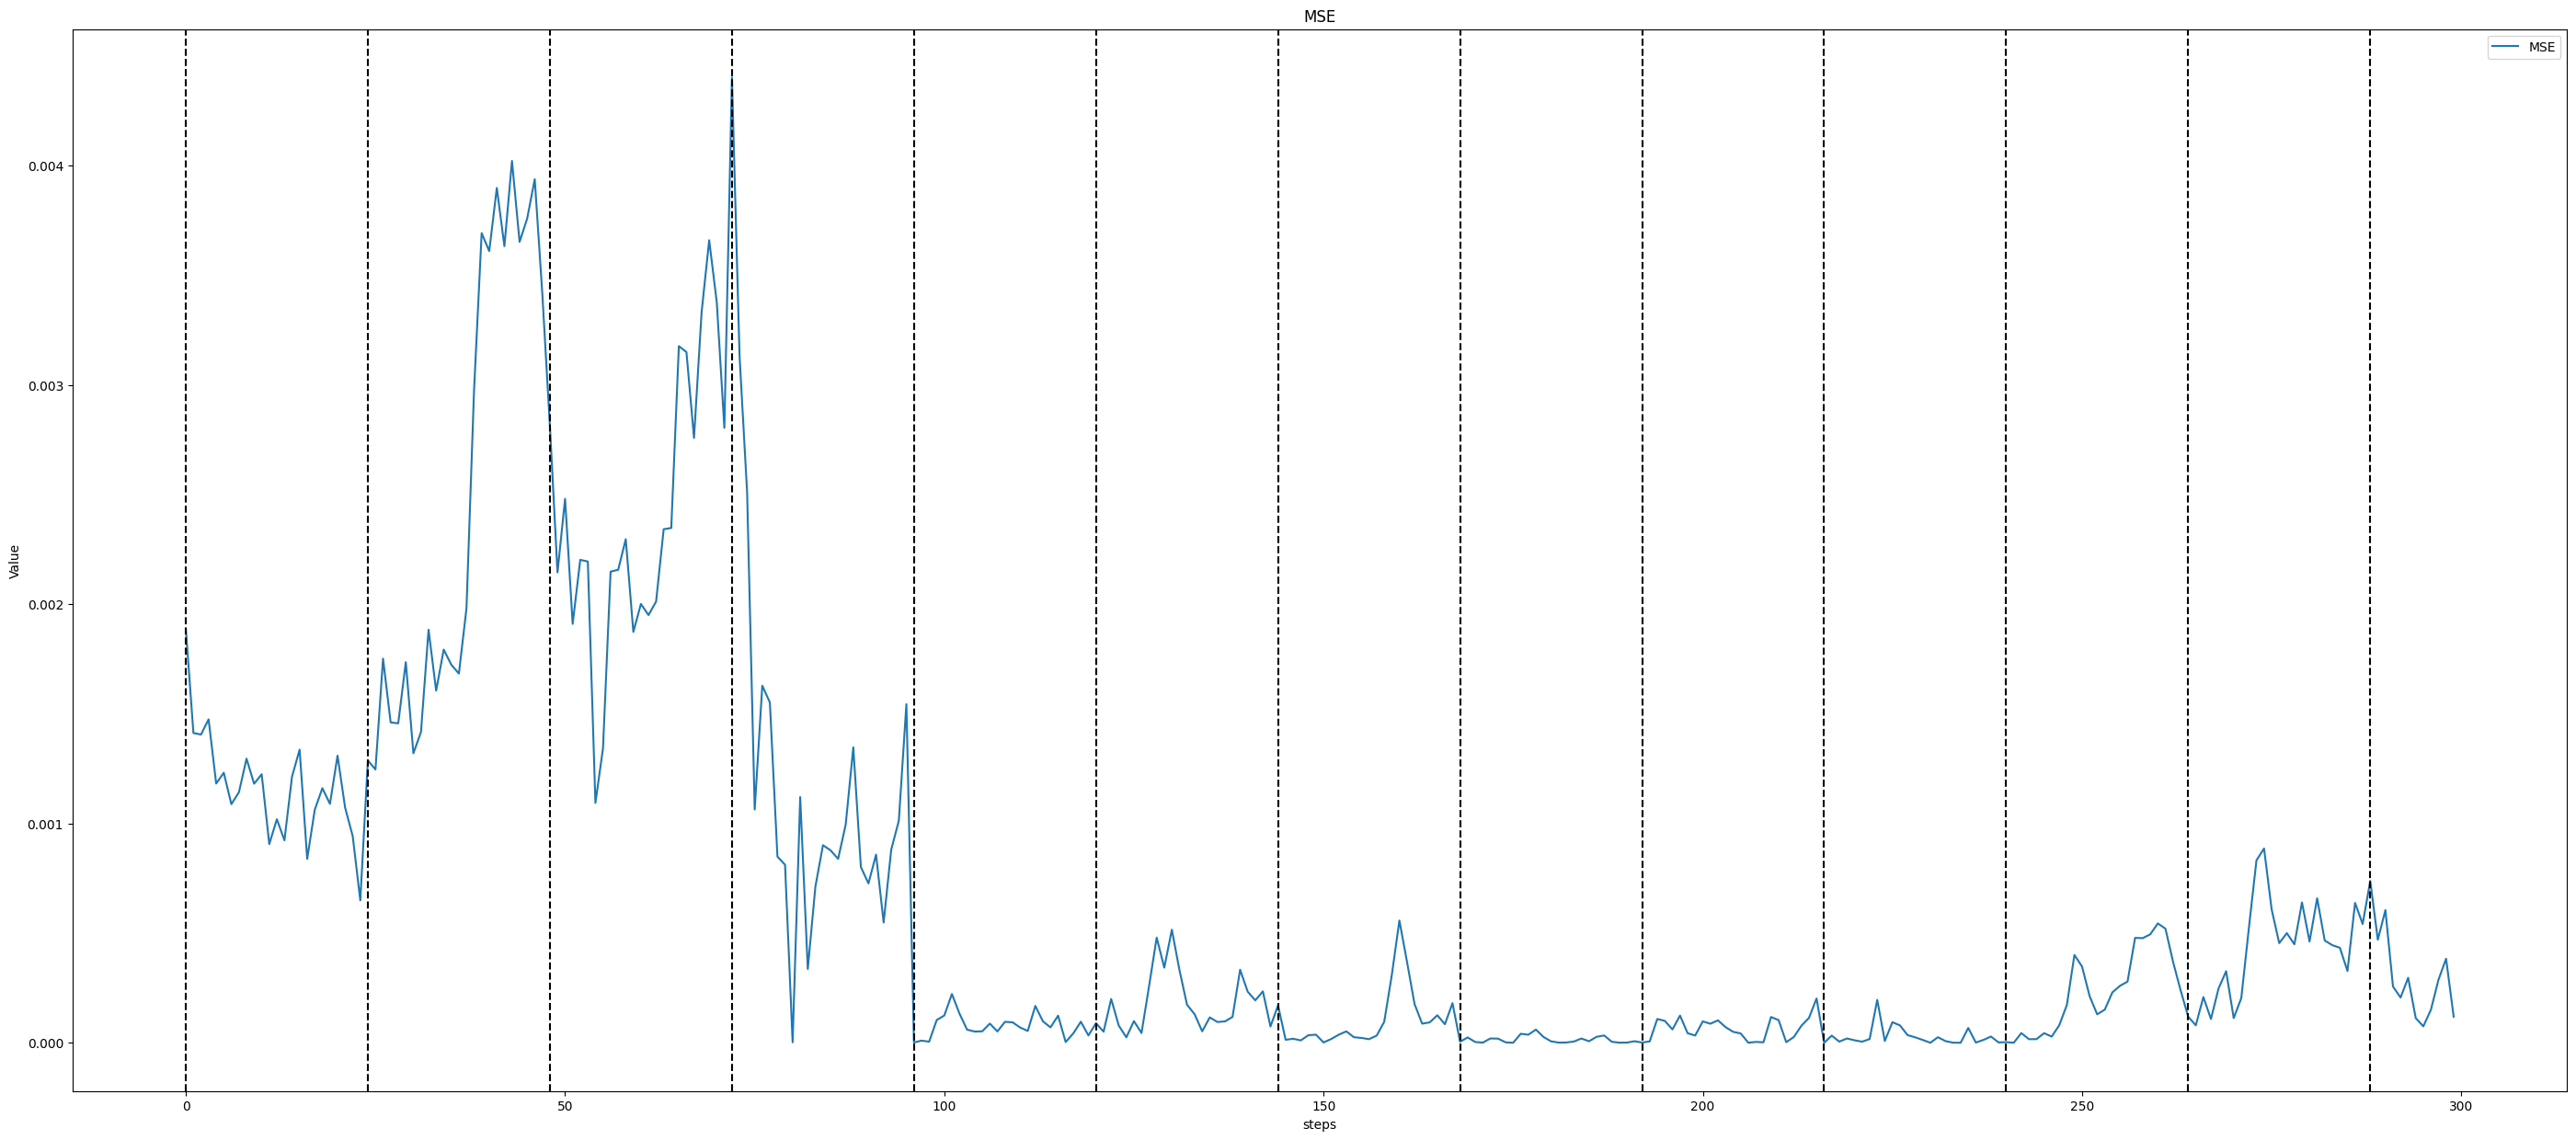

In [98]:
dfWresult = pd.DataFrame()


dfWresult["Y_true"] = y_true_flat_np
dfWresult["Y_pred"] = y_pred_flat_np




for i in range(len(dfWresult)):
   # Ensure the true and predicted values are passed as lists
   mse = mean_squared_error([dfWresult.at[i,"Y_true"]], [dfWresult.at[i,"Y_pred"]])
   dfWresult.at[i, "mse"] = mse

mse_mean = mean_squared_error(dfWresult["Y_true"], dfWresult["Y_pred"])

print(f"Mean MSE over dataset: {mse_mean}")

mse_mean1 = dfWresult["mse"].mean()

plt.figure(figsize=(35, 15))
plt.plot(dfWresult["mse"].iloc[:300], label='MSE')  # Corrected line
# Insert a vertical line every 24 steps
for i in range(0, 300, 24):
    plt.axvline(x=i, color='k', linestyle='--')
plt.title('MSE')
plt.xlabel('steps')
plt.ylabel('Value')
plt.legend()
plt.show()


# PROVA DEL 9 TEST SET

In [99]:
model = CNNLSTMModel(
    input_size=61,
    num_lstm_layers=config["model"]["num_lstm_layers"],
    dropout=config["model"]["dropout"],
    num_class=1,
    sequence_length=config["data"]["window_size"])

model.to(config["training"]["device"])


model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Model-PTH/hybridCNNLSTM24h_L1L2Verified_epoch_49_loss_0.0665.pth'))
model.eval()




print(f"trX input: {trX_tensor.shape}")
Xinput = trX_tensor[1,:,1]
Xinput_numpy = Xinput.detach().cpu().numpy().flatten()

inputTest = trX_tensor[1,:,:]
y_true = trY_tensor[0,:]
print(f"Xinput:{Xinput.shape} --- y_true:{y_true.shape} ---- inputtest:{inputTest.shape} ")

train_loss,avg_loss,all_predictions,all_targets = trainLoopT(model,test_loader)

print("Results________:")
print(f"AVG train test error over trainDataSet:{avg_loss}")
print(f"all_predictions dim {len(all_predictions)} & all_targets dim {len(all_targets)}")
#print(f"pred1 {all_predictions[1]} & target {all_targets[1]}")

class TestResults:
  def __init__(self, Xinput, y_true, y_pred, mse, rmse, r2):
      self.Xinput = Xinput
      self.y_true = y_true
      self.y_pred = y_pred
      self.mse = mse
      self.rmse = rmse
      self.r2 = r2

  def to_dataframe(self):
    return pd.DataFrame({
      "y_true": self.y_true,
      "y_pred": self.y_pred,
  })

  def resultPerformance(self):
    return pd.DataFrame({
          "MSE": [self.mse],
          "RMSE": [self.rmse],
          "R2": [self.r2]
      })
  def setMse(self, mse):
    self.mse = mse
  def setRmse(self, rmse):
    self.rmse = rmse
  def setR2(self, r2):
    self.r2 = r2

  def plot_results(self):
    df = self.to_dataframe()
    plt.figure(figsize=(15, 5))
        # Assuming the first item in "Xinput", "y_true", "y_pred" lists are what we want to plot
        # If "Xinput", "y_true", "y_pred" are nested lists, take the first element for plotting
    x_range = range(len(df['y_true'][0])) if isinstance(df['y_true'][0], list) else range(len(df['y_true']))
        # Xinput may not be used in scatter plot if its shape does not conform to the others
    plt.scatter(x_range, df['y_true'][0], label='True Value', color='blue')  # Assume first instance
    plt.scatter(x_range, df['y_pred'][0], label='Predicted Value', color='red')  # Assume first instance

    plt.title('Test Results')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

TestResult = TestResults(Xinput, all_targets, all_predictions, 0, 0,0)

trX input: torch.Size([1294, 200, 61])
Xinput:torch.Size([200]) --- y_true:torch.Size([1, 24]) ---- inputtest:torch.Size([200, 61]) 
Train loss: 0.00023639582286705263
Results________:
AVG train test error over trainDataSet:0.00023639582286705263
all_predictions dim 217 & all_targets dim 217


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [100]:
TestResult_df = TestResult.to_dataframe()
y_true = TestResult_df["y_true"]
y_pred = TestResult_df["y_pred"]
# If y_true and y_pred are lists of lists, we need to flatten them
# Flattening only needs to happen if y_true and y_pred are indeed lists of lists
y_true_flat = [item for sublist in y_true for item in sublist] if isinstance(y_true.iloc[0], list) else y_true
y_pred_flat = [item for sublist in y_pred for item in sublist] if isinstance(y_pred.iloc[0], list) else y_pred
# Now calculate the MSE, RMSE, and R2 score using the flattened lists
mse_test = mean_squared_error(y_true_flat, y_pred_flat)
rmse_test = mean_squared_error(y_true_flat, y_pred_flat, squared=False)
r2_test = r2_score(y_true_flat, y_pred_flat)
# Print the results
print(f"Test MSE: {mse_test}")
print(f"Test RMSE: {rmse_test}")
print(f"Test R2: {r2_test}")
# Update the TestResult object with the new computed metrics
TestResult.setMse(mse_test)
TestResult.setRmse(rmse_test)
TestResult.setR2(r2_test)

TestResult.resultPerformance().head()

Test MSE: 0.0002140607311136097
Test RMSE: 0.014630814437809322
Test R2: 0.9771703029937112


,MSE,RMSE,R2
0,0.000214,0.014631,0.97717


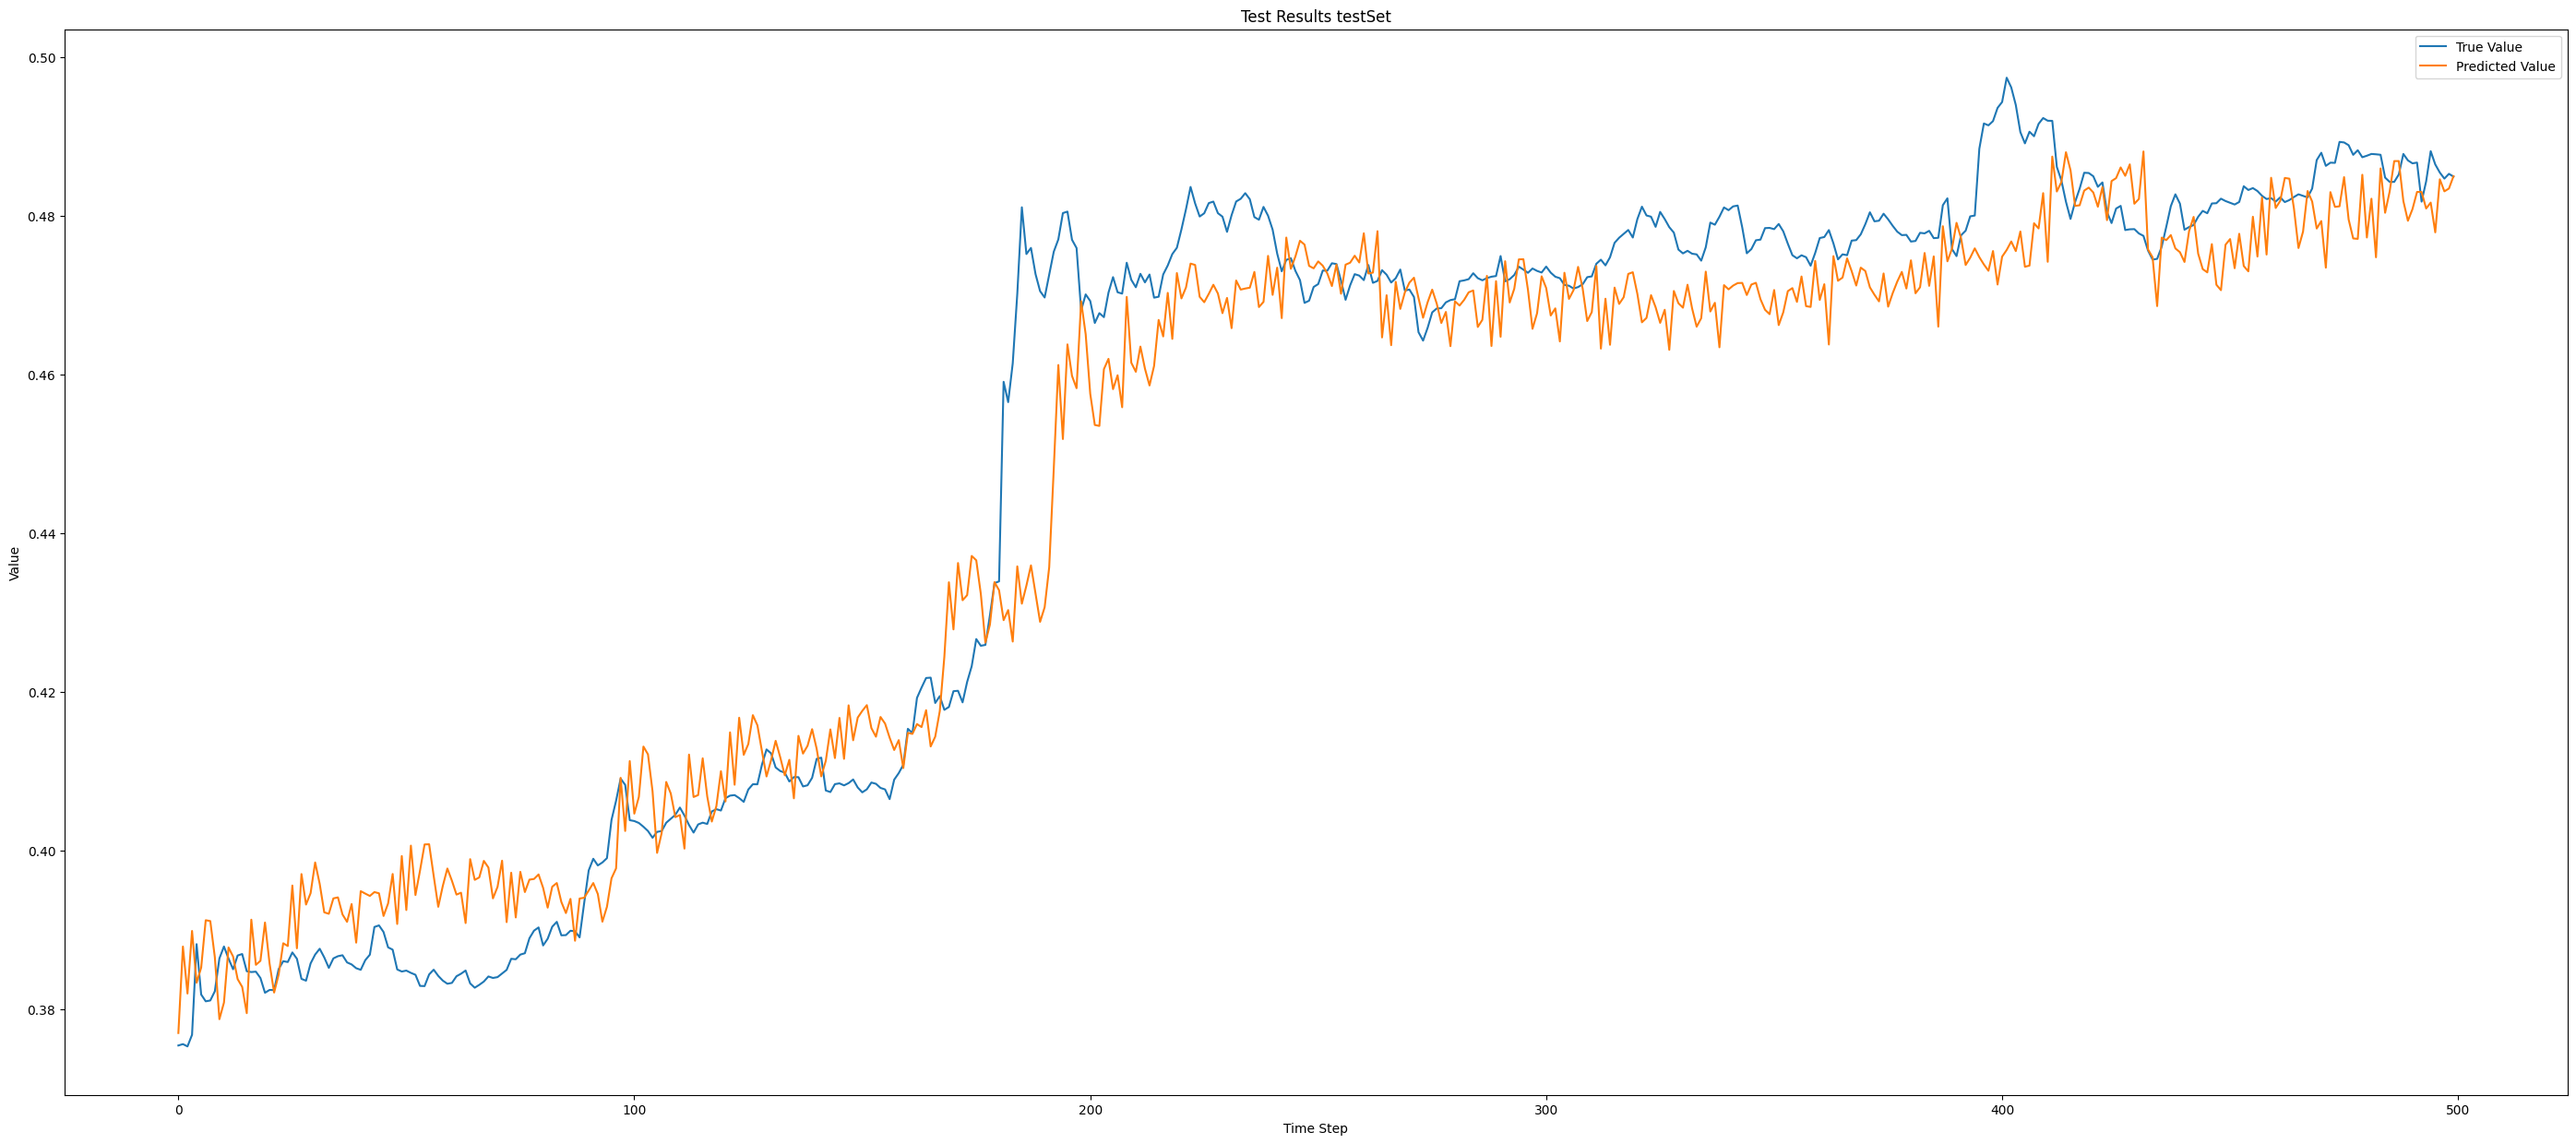

In [101]:
  plt.figure(figsize=(35, 15))
    #plt.plot(df['Xinput'], label='X input')
  plt.plot(y_true_flat[3000:3500], label='True Value')
  plt.plot(y_pred_flat[3000:3500], label='Predicted Value')
  plt.title('Test Results testSet')
  plt.xlabel('Time Step')
  plt.ylabel('Value')
  plt.legend()
  plt.show()

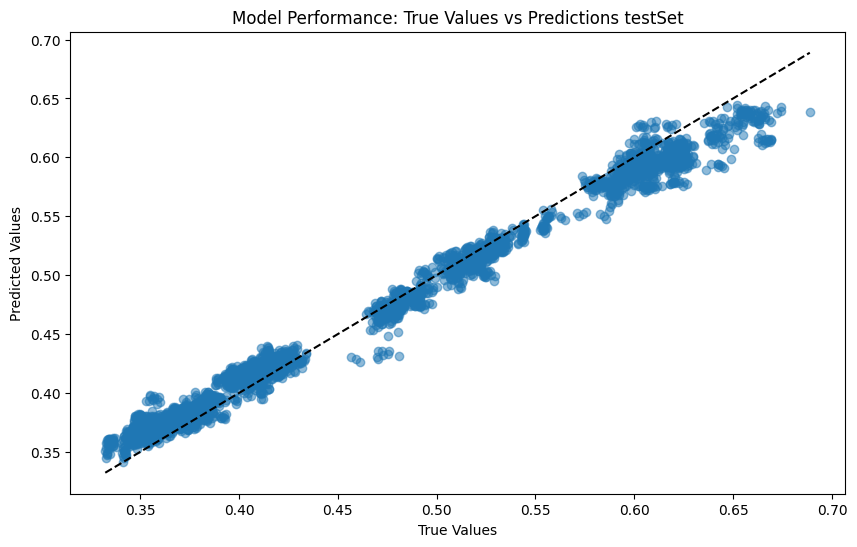

In [102]:
import matplotlib.pyplot as plt
import numpy as np  # Import numpy if it's not already

# Assuming y_true_flat and y_pred_flat are lists, convert them to NumPy arrays
y_true_flat_np = np.array(y_true_flat)
y_pred_flat_np = np.array(y_pred_flat)

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_true_flat_np, y_pred_flat_np, alpha=0.5)
plt.title('Model Performance: True Values vs Predictions testSet')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

# Plot the perfect prediction line
max_val = max(y_true_flat_np.max(), y_pred_flat_np.max())
min_val = min(y_true_flat_np.min(), y_pred_flat_np.min())
plt.plot([min_val, max_val], [min_val, max_val], 'k--')

plt.show()

Mean MSE over dataset: 0.0002140607311136097


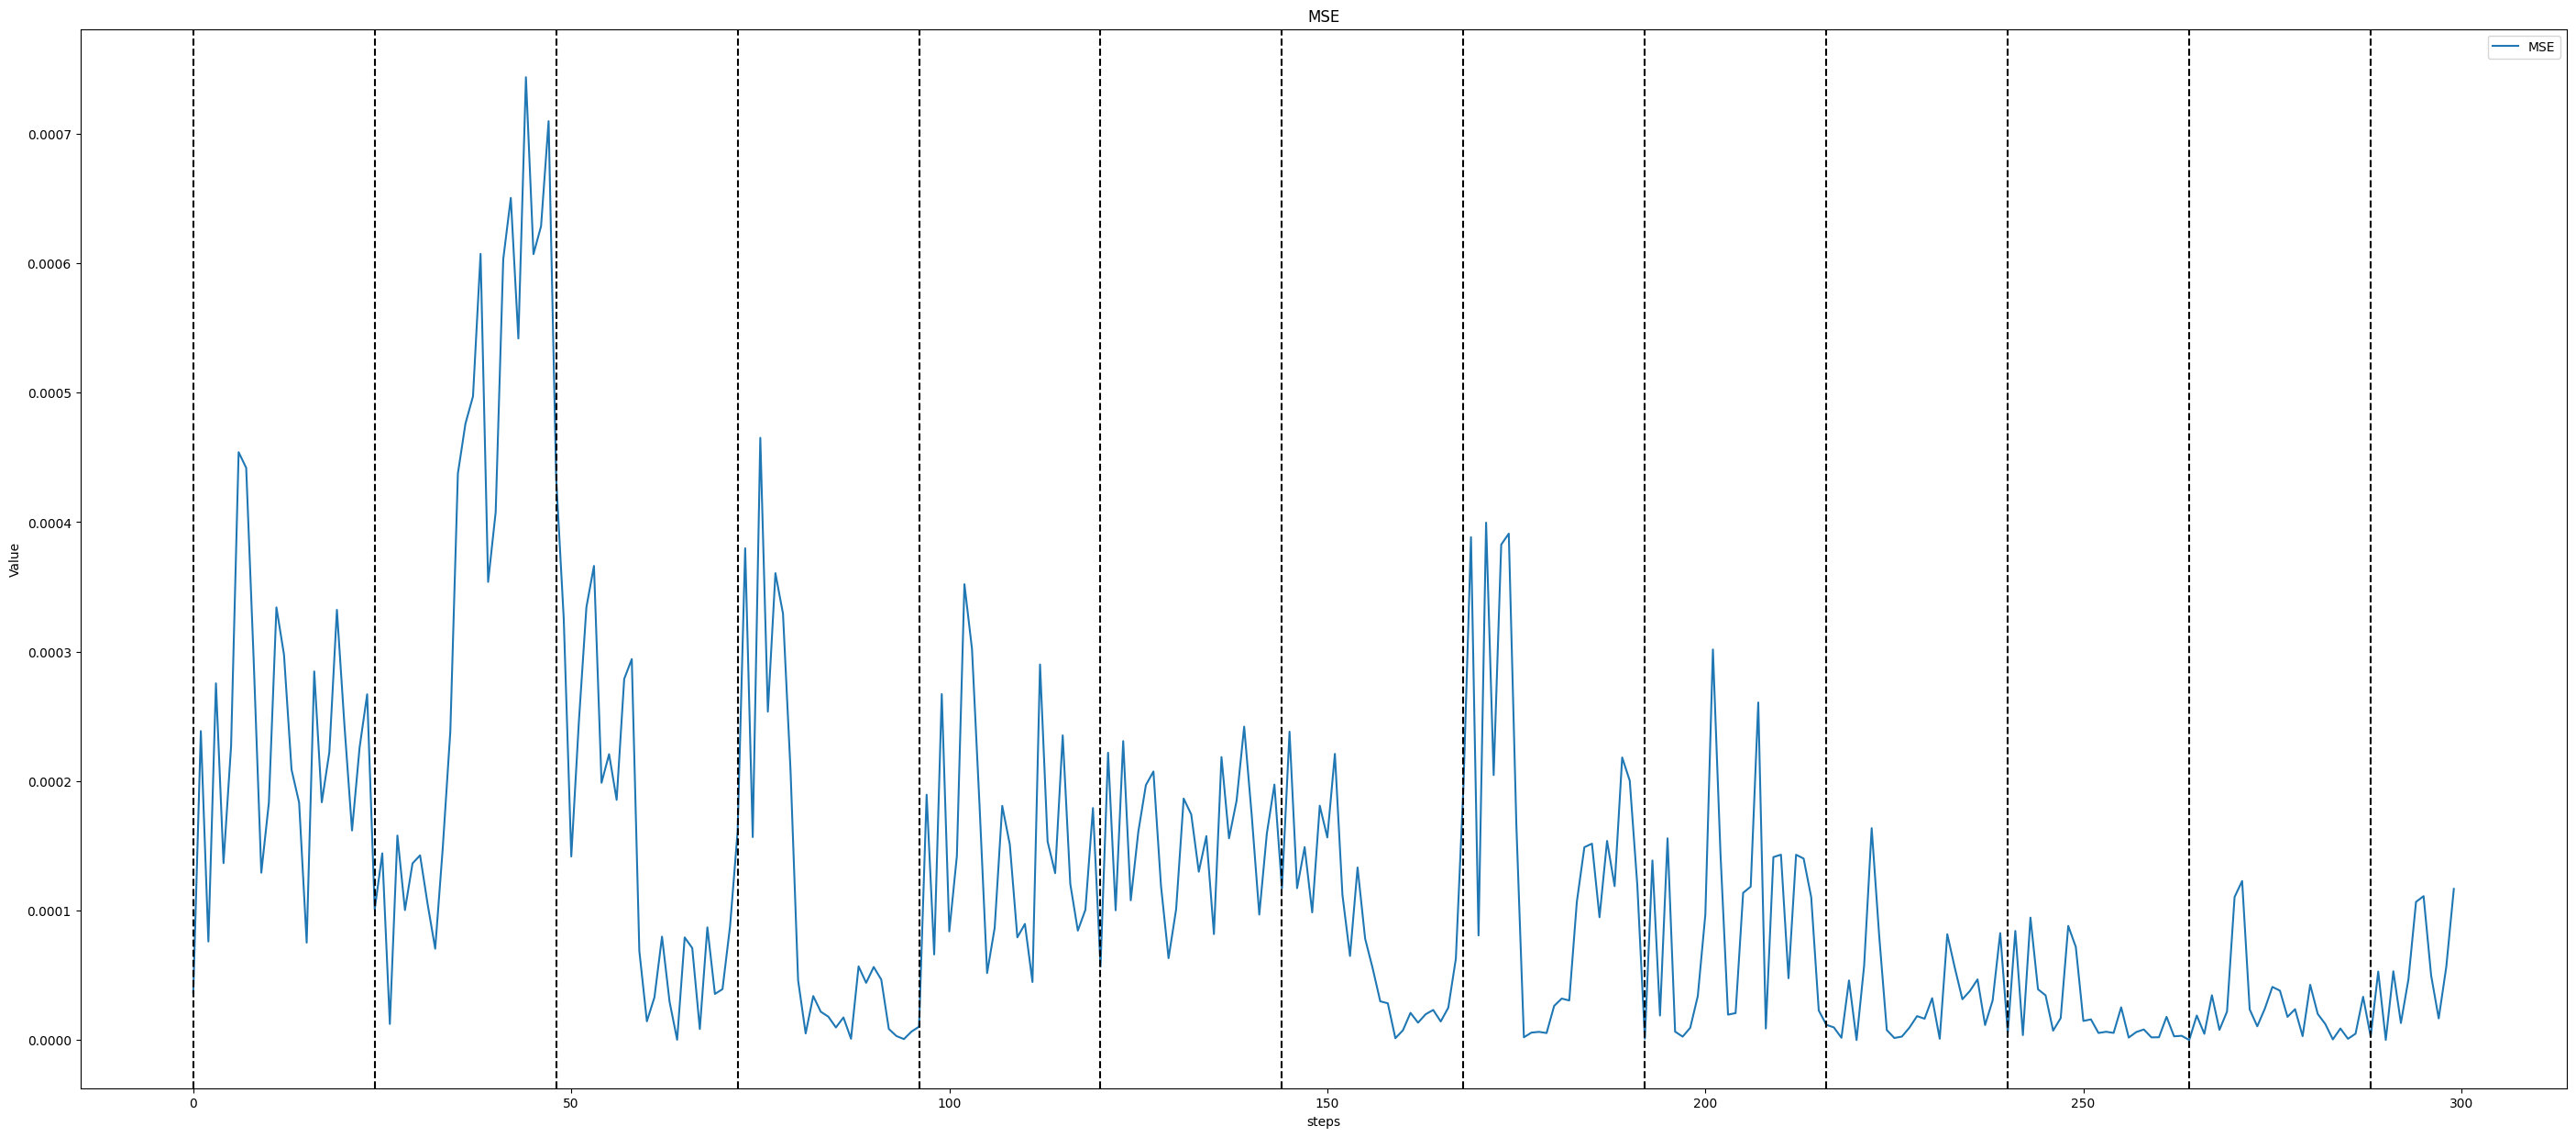

In [103]:
dfWresult = pd.DataFrame()


dfWresult["Y_true"] = y_true_flat_np
dfWresult["Y_pred"] = y_pred_flat_np




for i in range(len(dfWresult)):
   # Ensure the true and predicted values are passed as lists
   mse = mean_squared_error([dfWresult.at[i,"Y_true"]], [dfWresult.at[i,"Y_pred"]])
   dfWresult.at[i, "mse"] = mse

mse_mean = mean_squared_error(dfWresult["Y_true"], dfWresult["Y_pred"])

print(f"Mean MSE over dataset: {mse_mean}")

mse_mean1 = dfWresult["mse"].mean()

plt.figure(figsize=(35, 15))
plt.plot(dfWresult["mse"].iloc[:300], label='MSE')  # Corrected line
# Insert a vertical line every 24 steps
for i in range(0, 300, 24):
    plt.axvline(x=i, color='k', linestyle='--')
plt.title('MSE')
plt.xlabel('steps')
plt.ylabel('Value')
plt.legend()
plt.show()

In [104]:
import torchexplorer
dummy_X, dummy_y =  next(iter(test_loader))

torchexplorer.watch(model, log_freq=1, backend='standalone')


# questo lo metti nel training loop
# dummy_X = dummy_X.to(config["training"]["device"])
# model(dummy_X).sum().backward(

ModuleNotFoundError: No module named 'torchexplorer'